In [1]:
import plotly.express as px
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

Loading in data

In [2]:
def extract_xlsx(xlsx_name, ws_name):
  xlsx = pd.ExcelFile(xlsx_name)
  return pd.read_excel(xlsx, ws_name)

In [3]:
def merge_geo(shp_file_name, xlsx_file=None, csv_file_name=None):
    """
    This function takes the name of the shapes file and Excel workbook file OR
    a CSV file and returns a geospatial dataframe that joins these two datasets
    by state.
    """
    shp_file = gpd.read_file(shp_file_name)
    is_mainland = (shp_file['STUSPS'] != 'AK') & \
                  (shp_file['STUSPS'] != 'HI') & \
                  (shp_file['STUSPS'] != 'GU') & \
                  (shp_file['STUSPS'] != 'PR') & \
                  (shp_file['STUSPS'] != 'MP') & \
                  (shp_file['STUSPS'] != 'AS') & \
                  (shp_file['STUSPS'] != 'VI')
    shp_file = shp_file[is_mainland]

    if xlsx_file is None:
        csv_file = pd.read_csv(csv_file_name)
        csv_file = csv_file[
            (csv_file["State Name"] != "Alaska") &
            (csv_file["State Name"] != "Hawaii")
        ]
        merged_data = shp_file.merge(csv_file, left_on='STUSPS',
                                     right_on='State', how='outer')
    else:
        merged_data = shp_file.merge(xlsx_file, left_on="NAMELSAD",
                                     right_on="Location")
    return merged_data

Defining names for datasets

In [4]:
xlsx_file = extract_xlsx('Data/OverdoseDeathWA.xlsx', 'By Location and Date')
wa_geo_data = merge_geo("Data/geodata/cb_2022_us_county_500k.shp", xlsx_file)
national_geo_data = merge_geo("Data/geodata/cb_2022_us_county_500k.shp", csv_file_name="Data/NationalOverdose.csv")

(1) How has the number of drug overdose cases changed between 2015 and 2023 in Washington State?

In [6]:
def wa_overdose_change(wa_data:  pd.ExcelFile,
                       start: float = 2016.0,
                       end: float = 2022.0) -> None:
    """
    This function takes in the geospatial dataframe and returns the number
    of drug overdose cases in Washington from 2016-2023.
    """
    geography = wa_data["Geography"] == 'County'
    drug = wa_data["Drug Category"] == "Any Drug"
    year = (wa_data["Year"] >= start) & (wa_data["Year"] <= end)
    time = wa_data["Time Aggregation"] == "1 year rolling counts"
    remove_star = wa_data["Death Count"] != "*"
    county_data = wa_data[geography & drug & time & year & remove_star].copy()
    county_data["Death Count"] = county_data["Death Count"].astype("int")
    county_data = \
        county_data.groupby("Year").agg({"Death Count": "sum"}).reset_index()

    fig = px.line(
        county_data,
        x="Year",
        y="Death Count",
        title=f"Drug Overdose Deaths in WA between "
        f"{int(start)} and {int(end)}",
        markers=True
    )
    fig.update_layout(title_x=0.5, title_y=0.95, font=dict(size=15))
    fig.update_traces(line=dict(width=4), marker=dict(size=10))
    # fig.write_image('wa_overdose.png')
    fig.show()

In [7]:
wa_overdose_change(wa_geo_data)

In [11]:
def test_wa_overdose_change(data, start=2016.0, end=2022.0) -> pd.DataFrame:
    """
    This function takes in the geospatial dataframe and returns the number
    of drug overdose cases in Washington from 2016-2023.
    """
    wa_data = data[data["STATE_NAME"] == "Washington"].copy()
    drug = wa_data["Drug Category"] == "Any Drug"
    county = wa_data["Geography"] == "County"
    wa_data["Year"] = pd.to_numeric(data["Year"], errors="coerce")
    year = (wa_data["Year"] >= start) & (wa_data["Year"] <= end)
    time = wa_data["Time Aggregation"] == "1 year rolling counts"
    remove_star = wa_data["Death Count"] != "*"
    county_data = wa_data[drug & county & time & year & remove_star].copy()
    county_data["Death Count"] = county_data["Death Count"].astype("int")
    county_data = \
        county_data.groupby("Year").agg({"Death Count": "sum"}).reset_index()
    
    print('Printing table of death counts in Washington 2016-2022:')
    print()
    print(county_data)

In [12]:
test_wa_overdose_change(wa_geo_data)

Printing table of death counts in Washington 2016-2022:

     Year  Death Count
0  2016.0          979
1  2017.0         1082
2  2018.0         1095
3  2019.0         1173
4  2020.0         1667
5  2021.0         2181
6  2022.0         2571


(2) Which counties in Washington state have the highest number/rate of drug overdose cases?

In [12]:
def overdose_deaths_counties(data: gpd.GeoDataFrame, drug_name='Any Drug',
                             year_start=2016.0, year_end=2022.0) -> None:
    """
    This function takes in the geospatial dataframe and plots the drug
    overdose cases in different counties in Washington.
    """
    data = data[data['STATE_NAME'] == 'Washington'].copy()
    drug = data['Drug Category'] == drug_name
    county = data['Geography'] == 'County'
    time = (data['Time Aggregation'] == '1 year rolling counts')
    remove_star = data['Death Count'] != '*'
    county_data = data[drug & county & time & remove_star].copy()
    county_data['Death Count'] = county_data['Death Count'].astype('int')

    plt.figure(figsize=(15, 12))
    plt.subplots_adjust(hspace=0.2)
    plt.suptitle("Washington County Overdose Deaths", fontsize=18, y=0.95)
    n = int(year_end - year_start)
    height, width = n // 2 + 1, 2
    for i in range(int(year_start), int(year_end)+1):
        year = (county_data['Year'] == i)
        year_data = county_data[year]

        ax = plt.subplot(height, width, i - int(year_start)+1)

        data.plot(ax=ax, color='#d3d3d3')
        year_data.plot(ax=ax, column='Death Count', legend=True)
        ax.set_title(i)
        ax.set_aspect('equal')
    plt.savefig('counties_overdose.png')

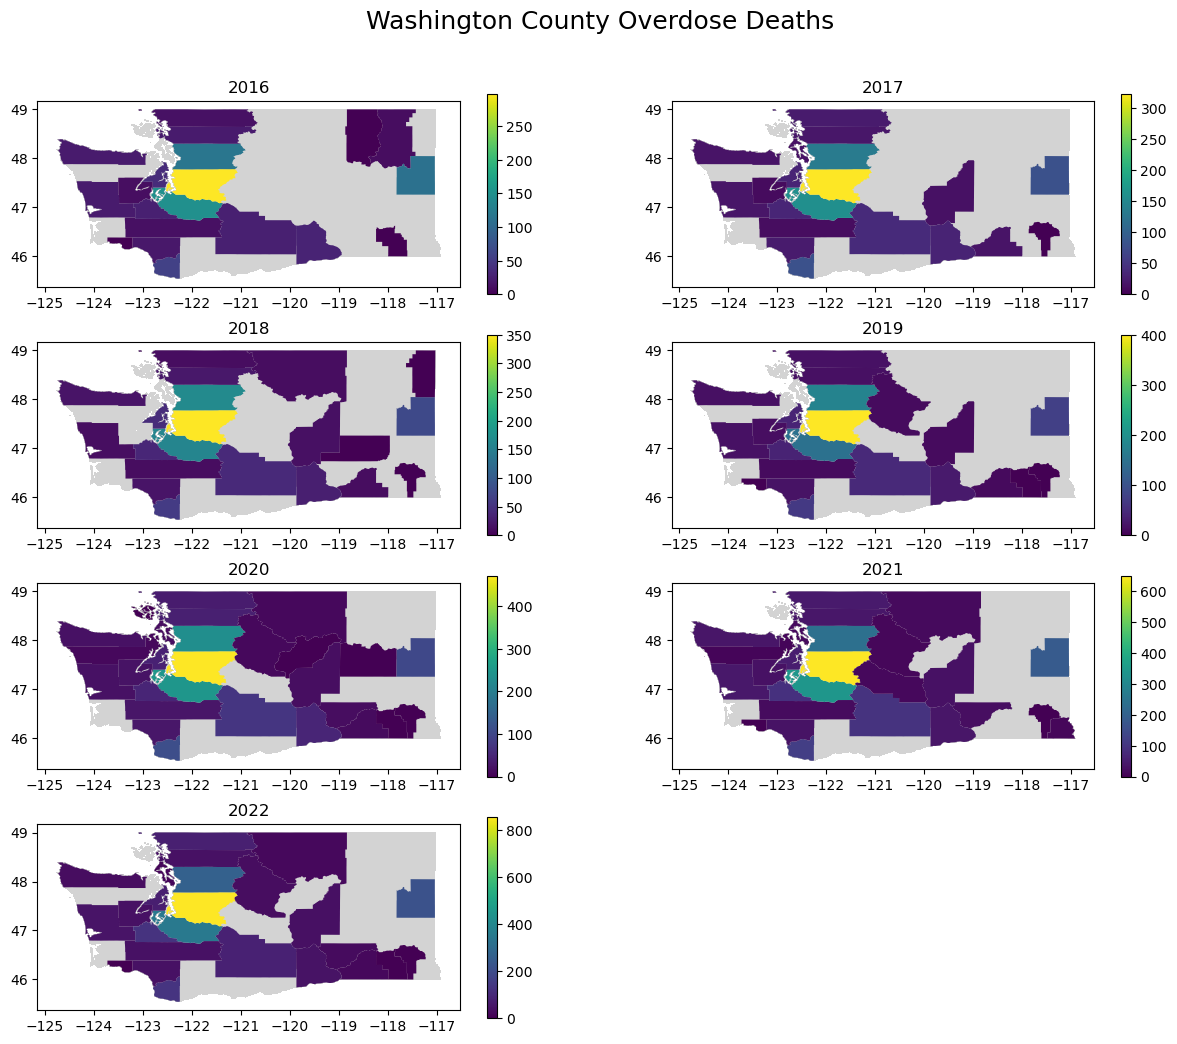

In [13]:
overdose_deaths_counties(wa_geo_data)

(3) How does the number of overdoses in WA compare to number of overdoses in other states in the USA?

In [9]:
shape = gpd.read_file('Data/geodata/cb_2022_us_county_500k.shp')
# shape

In [10]:
is_mainland = (shape['STUSPS'] != 'AK') & (shape['STUSPS'] != 'HI') & (shape['STUSPS'] != 'GU') & (shape['STUSPS'] != 'PR') & (shape['STUSPS'] != 'MP') & (shape['STUSPS'] != 'AS') & (shape['STUSPS'] != 'VI')
shape = shape[is_mainland]

In [9]:
shape['STUSPS'].unique()

array(['AL', 'AZ', 'AR', 'CA', 'CO', 'DE', 'FL', 'IL', 'GA', 'ID', 'MI',
       'IN', 'IA', 'NY', 'KS', 'KY', 'LA', 'ME', 'MD', 'MA', 'MN', 'MS',
       'MO', 'MT', 'NE', 'NJ', 'NM', 'NC', 'ND', 'OH', 'OK', 'OR', 'PA',
       'SC', 'SD', 'TN', 'TX', 'WV', 'UT', 'VT', 'VA', 'WA', 'WI', 'WY',
       'CT', 'RI', 'NV', 'NH', 'DC'], dtype=object)